In [1]:
import os
import time
import math
import psutil
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, desc

If LOCAL_SCRATCH_DIR environment variable is not set, this notebook accesses the ../data directory for temporary files.

In [2]:
DATA_DIR = os.getenv("LOCAL_SCRATCH_DIR", default="../data")
filename = os.path.join(DATA_DIR, "gene_info.tsv")
print("Filename:", filename)

Filename: ../data/gene_info.tsv


Get number of physical and logical cores (with hypherthreading)

In [3]:
physical_cores = psutil.cpu_count(logical=False)
logical_cores = psutil.cpu_count(logical=True)

In [4]:
print(f"Physical cores: {physical_cores}")
print(f"Logical cores: {logical_cores}")

Physical cores: 4
Logical cores: 8


In [5]:
n = round(math.log(physical_cores, 2))
cores = [2**i for i in range(n+1)]
print(cores)

[1, 2, 4]


In [6]:
timing = []
for num_cores in cores:
    start = time.time()
    
    spark = SparkSession.builder.master(f"local[{num_cores}]").appName("SparkDataframe").getOrCreate()
    # read only specified columns
    column_names = ["GeneID", "Symbol", "Synonyms", "description", "type_of_gene", "#tax_id", "chromosome"]

    genes = spark.read.option("header","true").option("sep", "\t").csv(filename)
    genes = genes.select(column_names)
    genes = genes.withColumnRenamed("#tax_id", "tax_id")
    genes = genes.filter("type_of_gene == 'protein-coding'")
    
    groups = genes.groupBy(["tax_id"]).count()
    groups = groups.toDF("tax_id", "count")
    groups = groups.toDF("tax_id", "count")
    groups = groups.sort(col("count").desc())
    groups = groups.toPandas()
    #groups.query("tax_id == '9606'")
    #groups.head()
    spark.stop()
                         
    end = time.time()
    print(num_cores, (end-start))
    timing.append({"cores": num_cores, "time": end-start})

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


1 100.89631724357605


2 39.769089221954346


4 25.178843021392822


In [7]:
df = pd.DataFrame(timing)

In [8]:
df["best"] = df["time"].iloc[0] / df["cores"]

In [9]:
df

,cores,time,best
0,1,100.896317,100.896317
1,2,39.769089,50.448159
2,4,25.178843,25.224079


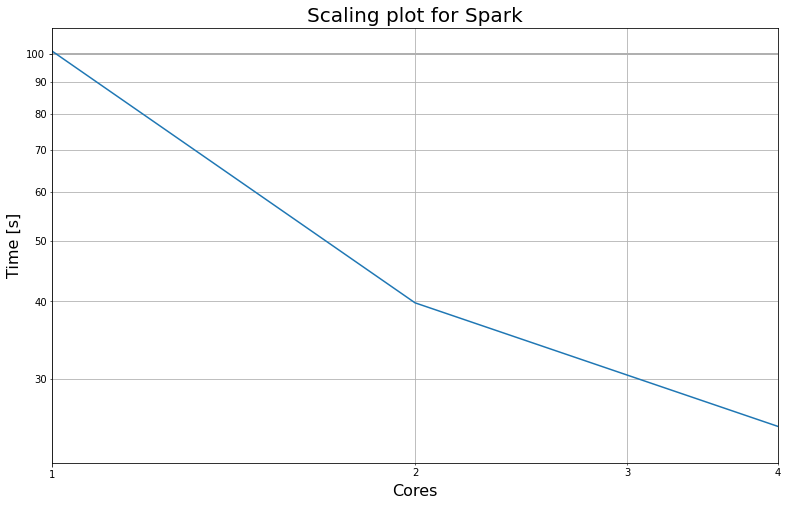

In [11]:
fig, ax = plt.subplots(figsize=(13, 8))
ax.loglog()
for axis in [ax.xaxis, ax.yaxis]:
    formatter = matplotlib.ticker.FormatStrFormatter("%d")
    axis.set_major_formatter(formatter)
    axis.set_minor_formatter(formatter)
ax.grid(visible=True, which='major', linewidth=2)
ax.grid(visible=True, which='minor')
plt.title("Scaling plot for Spark", fontsize=20)
plt.xlabel("Cores", fontsize=16)
plt.ylabel("Time [s]", fontsize=16)
plt.xlim([1, physical_cores])
plt.ylim([22, 110])
ax.plot(df["cores"].values, df["time"].values);

In [22]:
df["efficiency"] = df["time"].iloc[0] / (df["time"] * df["cores"])

In [23]:
df

,cores,time,best,efficiency
0,1,100.896317,100.896317,1.000000
1,2,39.769089,50.448159,1.268527
2,4,25.178843,25.224079,1.001797
